In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

# Select GPU
torch.cuda.set_device(5)
torch.cuda.current_device()

import warnings
from pathlib import Path
from wrappers.transformer_wrapper import FairseqTransformerHub

import alignment.align as align

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()

logger.setLevel('WARNING')
warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

In [3]:
data_sample = 'generate' # generate/interactive
teacher_forcing = False # teacher forcing/free decoding

green_color = '#82B366'
red_color = '#B85450'

In [4]:
# Paths
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])
iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR'])
gold_dir = Path(os.environ['GOLD_ALIGNMENT_DATA_DIR'])
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

# Choose model
model_type = 'baseline'
seed = 5498 # 2253  2453  5498  9240	9819

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(), # processed data
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(), 
)
NUM_LAYERS = 6


## Get example for analysis

From provided test data (preprocessed folder)

In [33]:
# Get sample from provided test data

if data_sample == 'generate':
    # index in dataset
    i = 29

    sample = hub.get_sample('test', i)

    src_tensor = sample['src_tensor']
    tgt_tensor = sample['tgt_tensor']
    src_tok = sample['src_tok']
    src_sent = sample['src_sent']
    tgt_sent = sample['tgt_sent']
    print(f"\nSource sentence: \t {src_sent}")
    print(f"Target sentence: \t {tgt_sent}")


Source sentence: 	 auch ist wichtig , daß europa das rehabilitationsprogramm unterstützt .
Target sentence: 	 european support for rehabilitation programmes is also essential .


In [34]:
if data_sample == 'interactive':
    # index in dataset
    i = 120 # index in dataset
    #test_set_dir = europarl_dir / "processed_data/"

    test_set_dir = iwslt14_dir / "tokenized/"
    test_set_dir = gold_dir / "tokenized/"
    src = "de"
    tgt = "en"
    tokenizer = "bpe"
    sample = hub.get_interactive_sample(i, test_set_dir, src,
                                        tgt, tokenizer, hallucination=None)# '▁unk'
    src_tensor = sample['src_tensor']
    tgt_tensor = sample['tgt_tensor']
    src_tok = sample['src_tok']

    print(sample['src_word_sent'])
    print(sample['tgt_word_sent'])

### Teacher Forcing

In [35]:
if teacher_forcing:
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print("\n\nGREEDY DECODING\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
    pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")

    source_sentence = src_tok
    target_sentence = sample['tgt_tok']
    predicted_sentence = pred_tok



### Greedy decoding/Beam search

For greedy decoding, set beam=1

In [42]:
if not teacher_forcing:
    tgt_tensor_free = []
    # Add tokens to prefix_tokens to force decoding with initial tokens
    # We use token id = 3 (unk) to generate hallucinations
    # prefix_tokens = torch.tensor([[3]]).to('cuda')
    # inference_step_args={'prefix_tokens': prefix_tokens}
    inference_step_args = None

    print("\n\nBEAM SEARCH\n")
    for pred in hub.generate(src_tensor, beam=1, inference_step_args = inference_step_args):
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=True)
        score = pred['score'].item()
        print(f"{score} \t {pred_sent}")

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]

    pred_tok = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=False)
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.tgt_dict.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    tgt_tok = hub.decode(tgt_tensor, hub.task.tgt_dict, as_string=False)
    target_sentence = tgt_tok
    source_sentence = src_tok
    predicted_sentence = pred_tok

    # model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    # print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")
    # pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    # pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
    # pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
    # print(f"Predicted sentence: \t {pred_sent}")
    # predicted_sentence = pred_tok



BEAM SEARCH

-0.1936861127614975 	 it is also important that europe supports the rehabilitation programme .


## Layer-wise Analysis

### Attention weights cross-attention

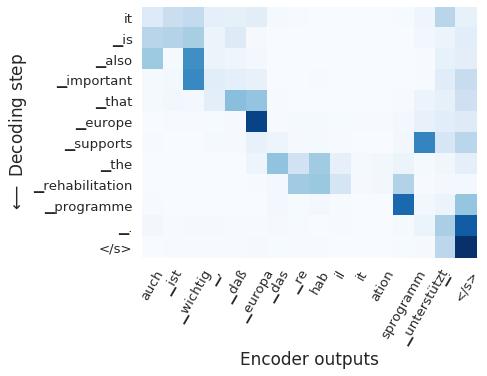

In [44]:
layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'attn_w', norm_mode='sum_one')['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(6,6))
df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence + ['</s>'],index=predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel('Encoder outputs', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(rotation=60);

mean residual 0.7530497 std 0.12101336


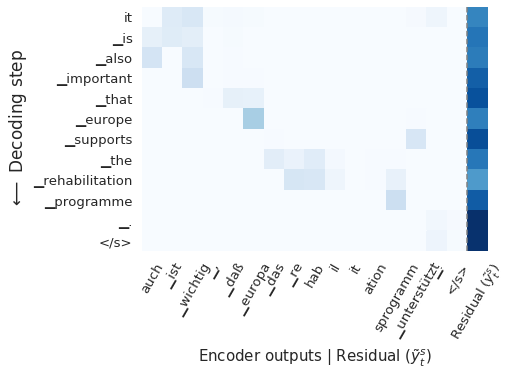

In [45]:
layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(6.2,6.2))

df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence + ['</s>'] + ['Residual'],index=predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel(r'Encoder outputs | Residual $(\tilde{y}^{s}_{t})$', fontsize=15)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)


plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(ticks = plt.gca().get_xticks(), labels=source_sentence + ['</s>'] + [r'Residual $(\tilde{y}^{s}_{t})$'], rotation=60)
# for i, xtick in enumerate(plt.gca().get_xticklabels()):
#     plt.gca().get_xticklabels()[i].set_color(green_color)
#plt.gca().get_xticklabels()[-1].set_color(red_color)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

#plt.title('Contributions')

print('mean residual',df['Residual'].mean(), 'std', df['Residual'].std())


Total decoder layer contributions $[\mathbf{C}_{\widetilde{\mathbf{y}}\gets\mathbf{e}};\mathbf{C}_{\widetilde{\mathbf{y}}\gets\mathbf{y}_{<t}}]$ with the self-attention contributions included

Corresponds to Figure 8-c

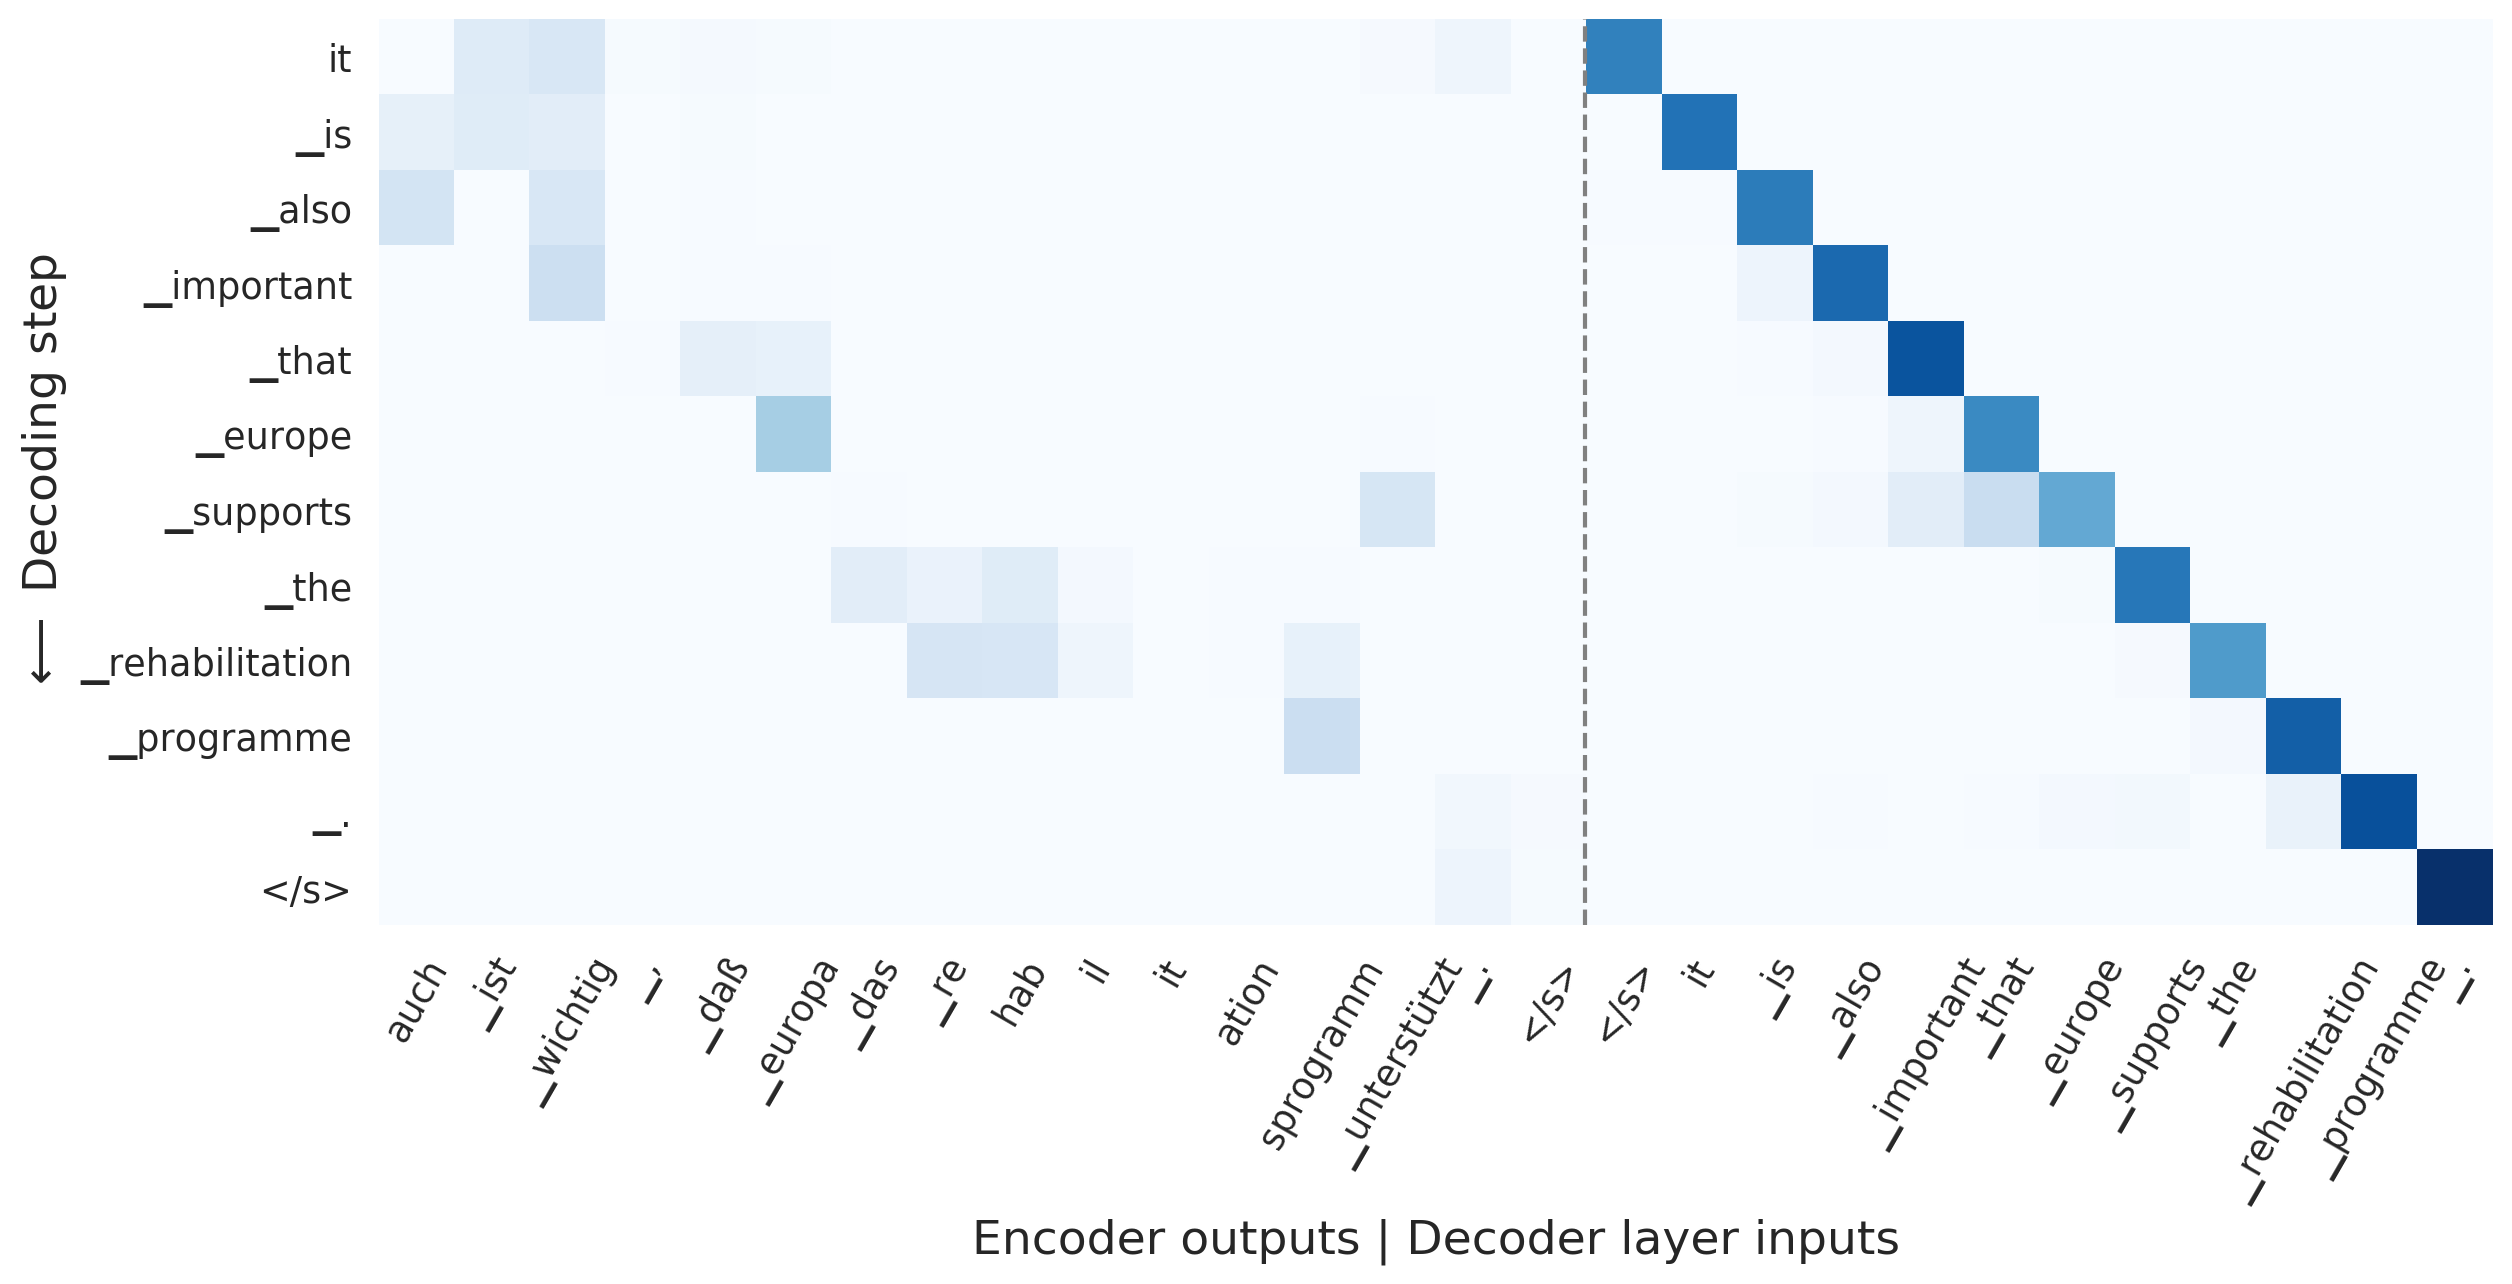

In [46]:
layer = 4
self_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
cross_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
cross_contributions_layer = cross_contributions[layer]

self_dec_contributions_layer = (self_dec_contributions[layer].transpose(0,1)*cross_contributions_layer[:,-1]).transpose(0,1)
cross_contributions_layer = cross_contributions_layer[:,:-1]
final_cross_contributions = torch.cat((cross_contributions_layer,self_dec_contributions_layer),dim=1)
final_cross_contributions_np = final_cross_contributions.detach().cpu().numpy()
plt.figure(figsize=(15,6),dpi=200)
df = pd.DataFrame(final_cross_contributions_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
s = sns.heatmap(df,cmap="Blues",square=True, cbar=False)
s.set_xlabel('Encoder outputs | Decoder layer inputs', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)
plt.xticks(rotation=60)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15
src_len = len(source_sentence + ['</s>'])
tgt_len = len(predicted_sentence + ['</s>'])


## ALTI analysis

### ALTI of the encoder

To check the mixing of information inside the decoder

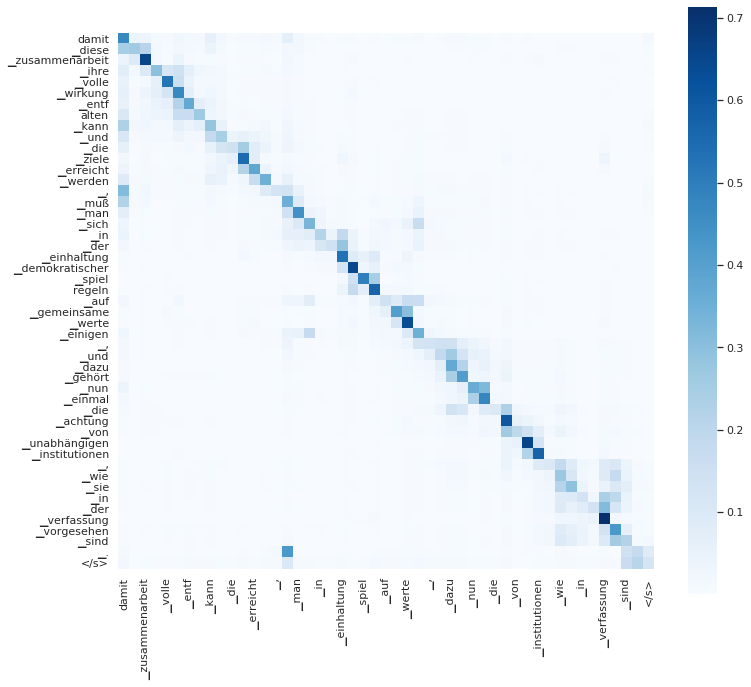

In [20]:
relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn']
layer = -1
# Encoder self-attention relevances in last layer (full encoder ALTI)
plt.figure(figsize=(12,12))
df = pd.DataFrame(relevances_enc_self_attn[layer].cpu().detach().numpy(),columns= source_sentence + ['</s>'], index= source_sentence + ['</s>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

Attention weights (raw) in the cross attention at selected layer.
Corresponds to Figure 8-a of the paper

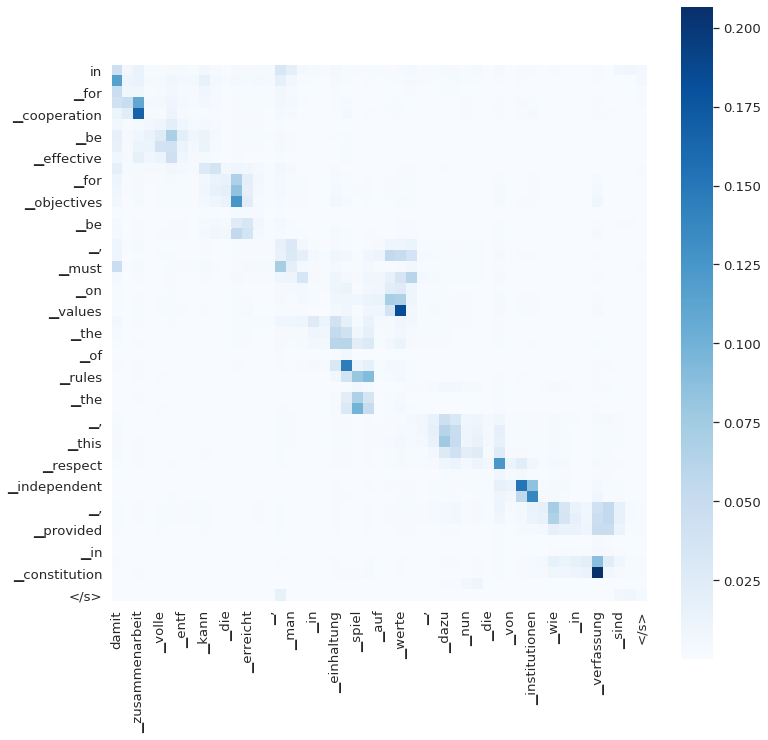

In [21]:
layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])
combined_alti_enc_cross = torch.matmul(cross_attn_contributions[layer][:,:-1],relevances_enc_self_attn[-1])
df = pd.DataFrame(combined_alti_enc_cross.detach().cpu().numpy(), columns=source_sentence + ['</s>'], index=predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
sns.heatmap(df,cmap="Blues",square=True)

### ALTI+

ALTI+ for the entire model. Last layer heatmap shows relevances of input tokens to the model prediction: $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{x}}$ | $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{\mathbf{y}_{<t}}}$

In [25]:
total_alti = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total']

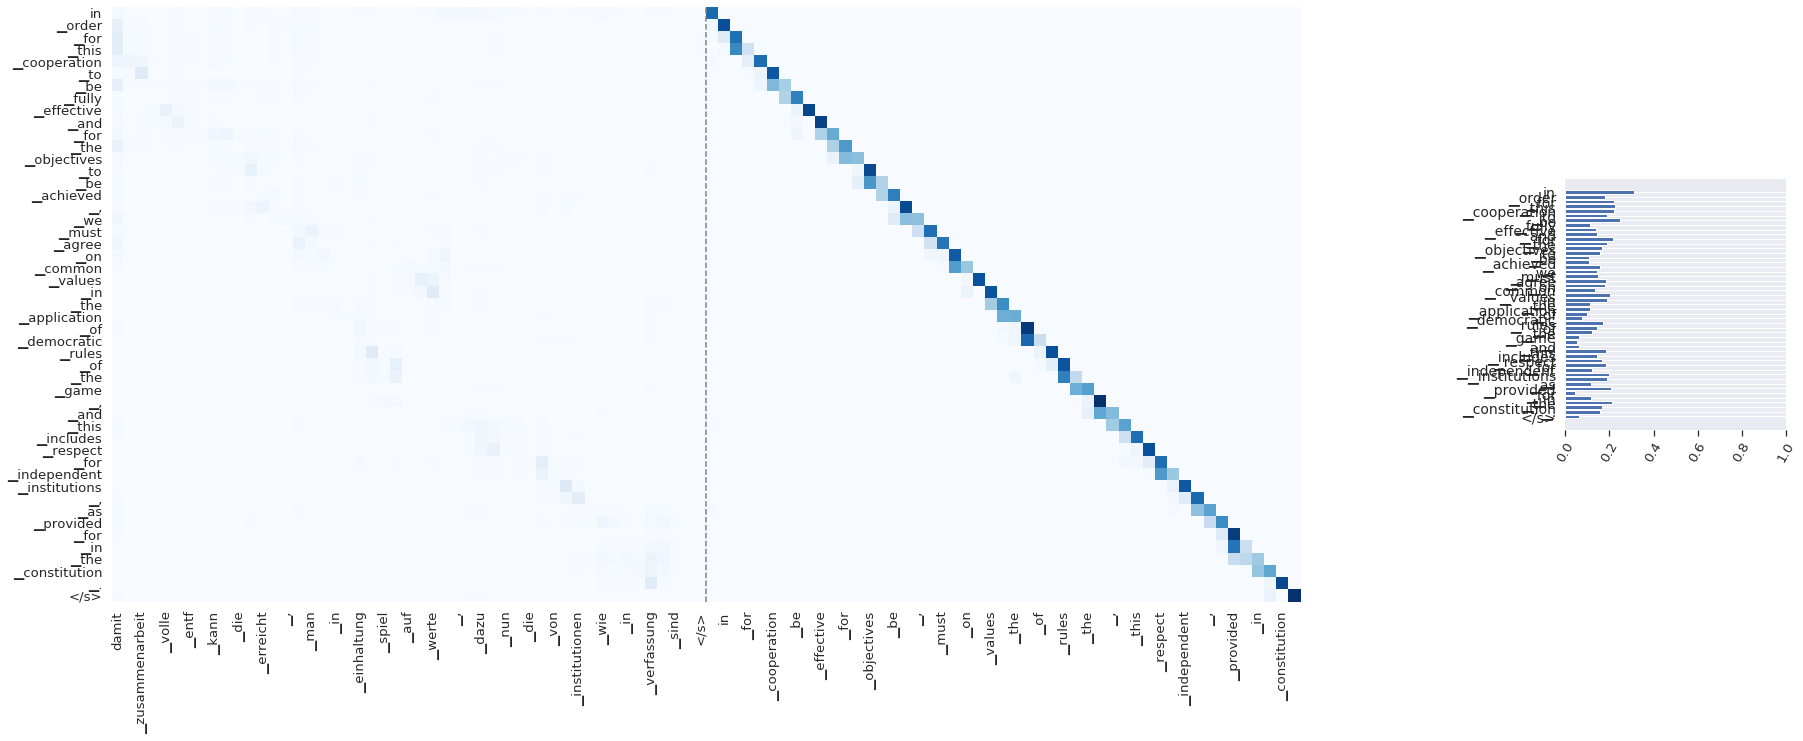

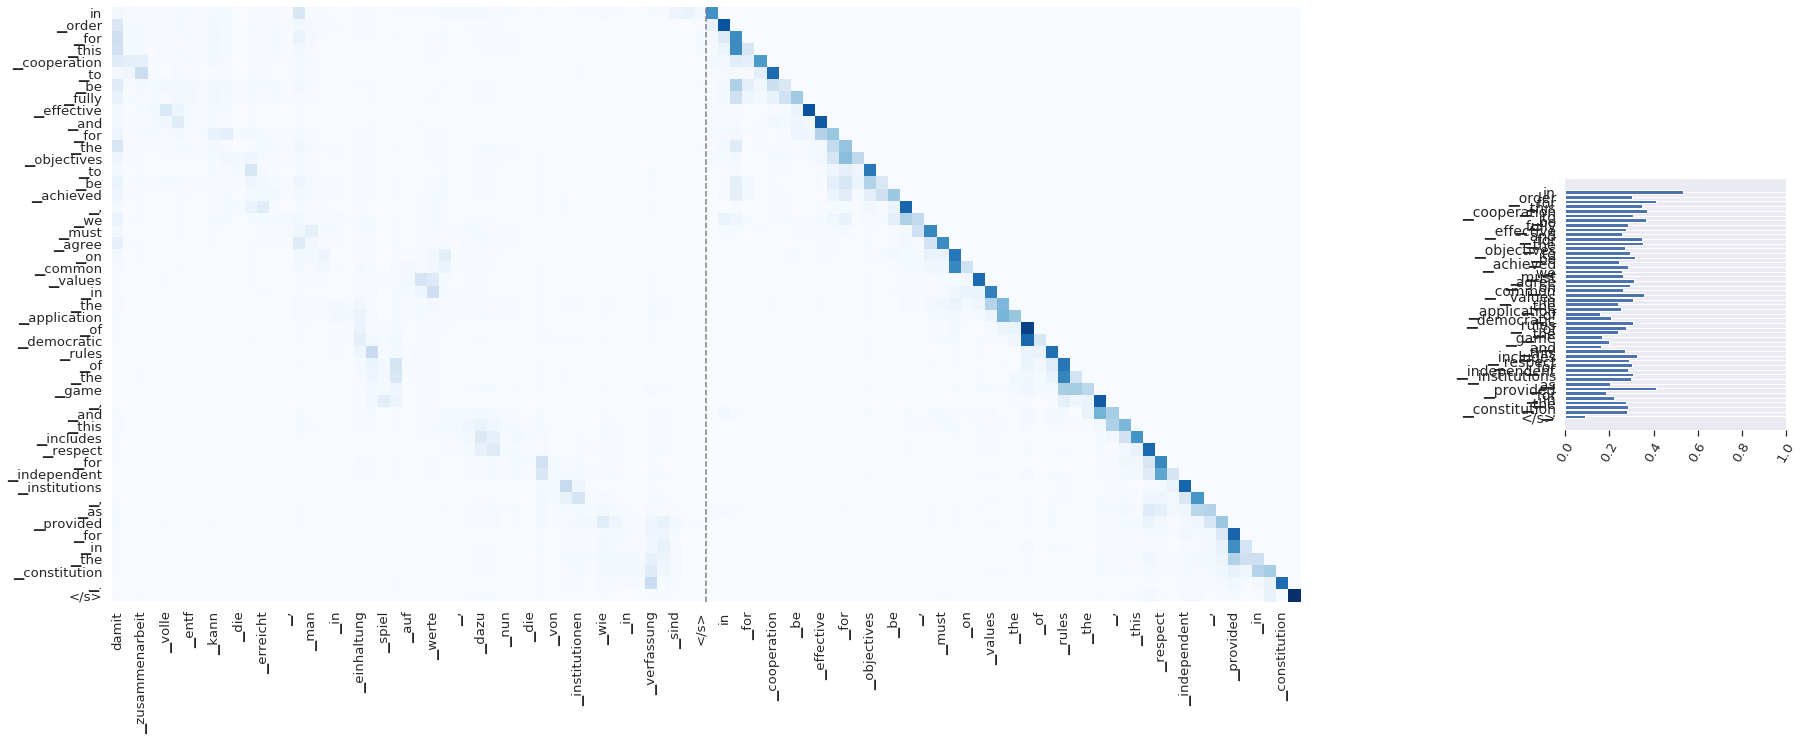

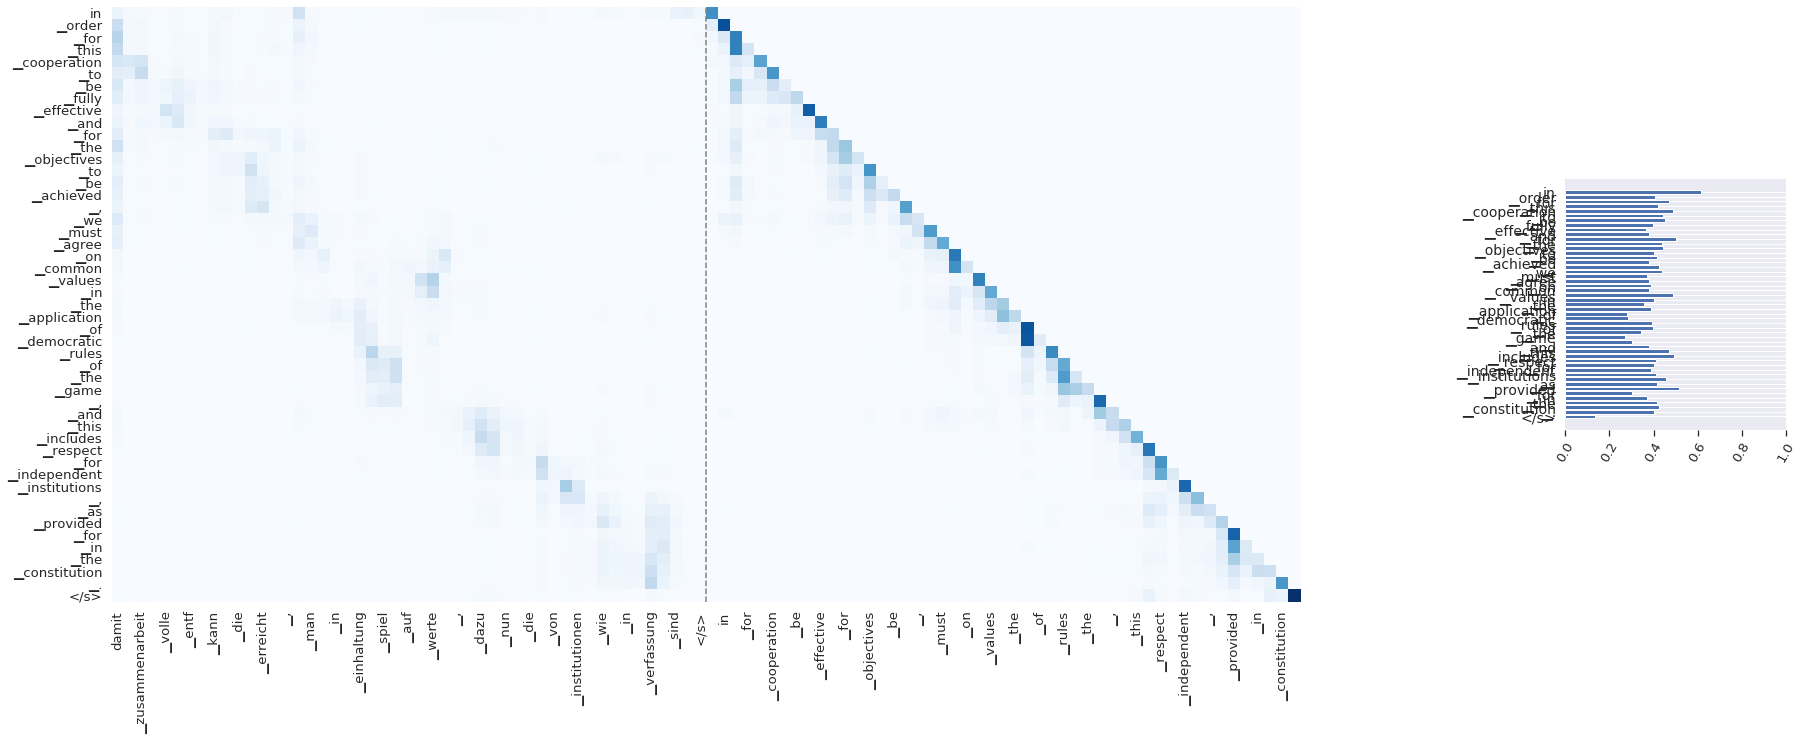

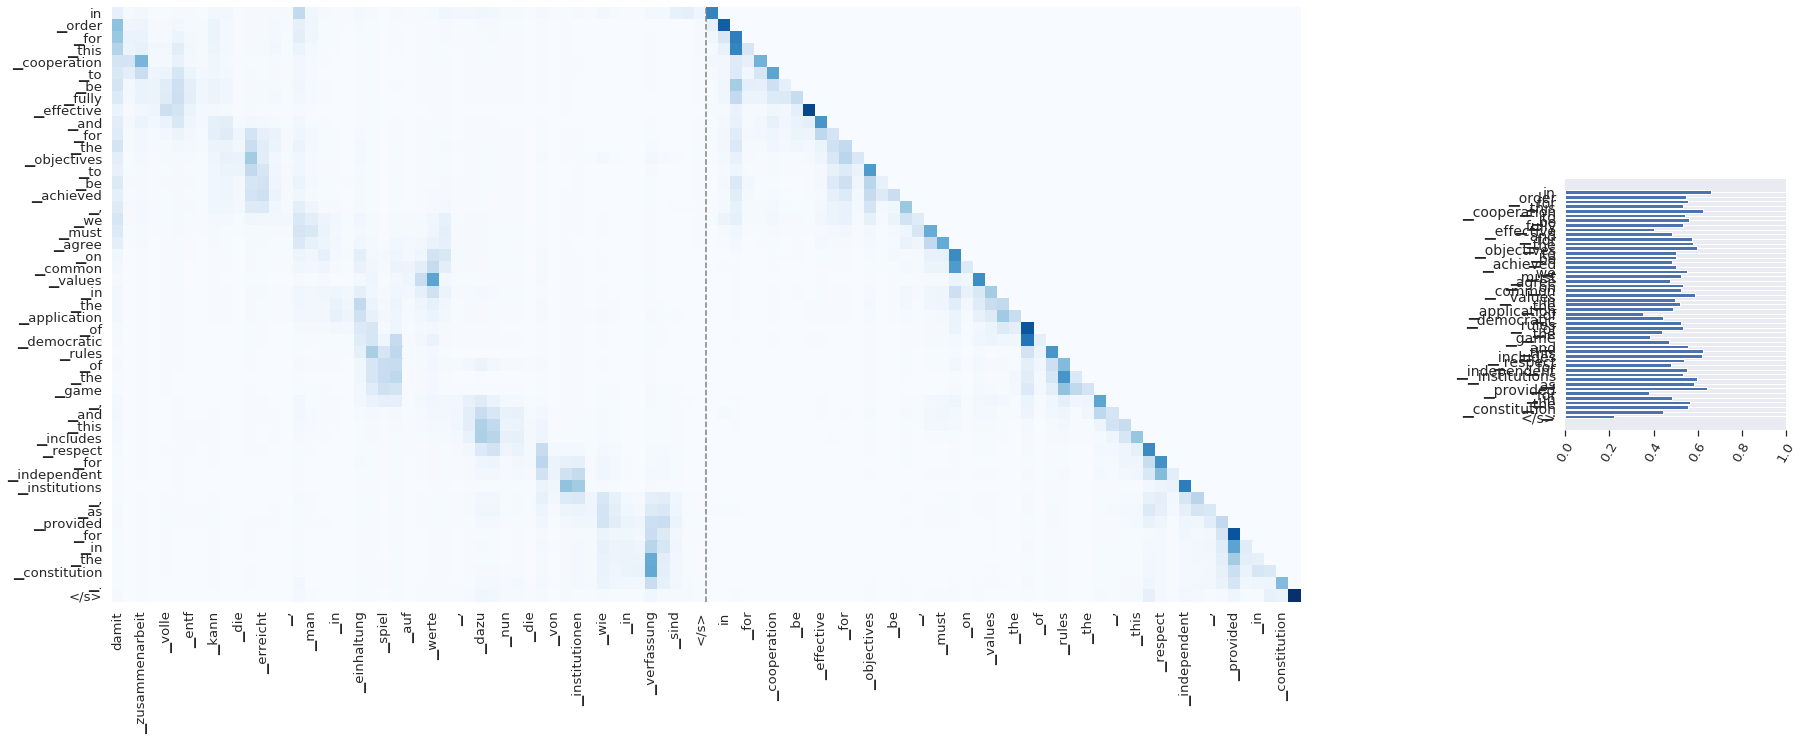

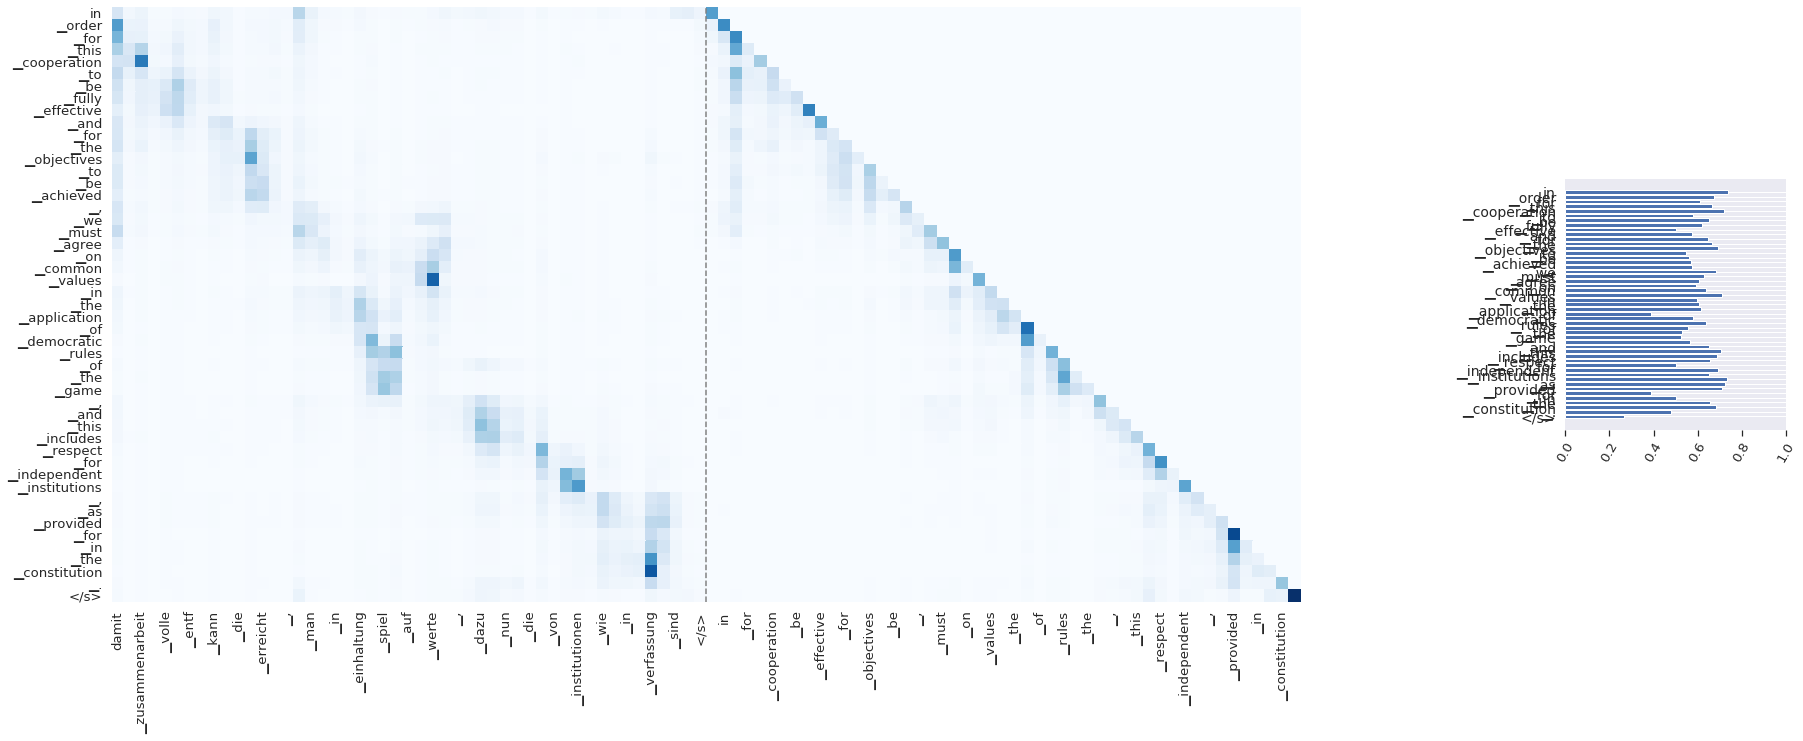

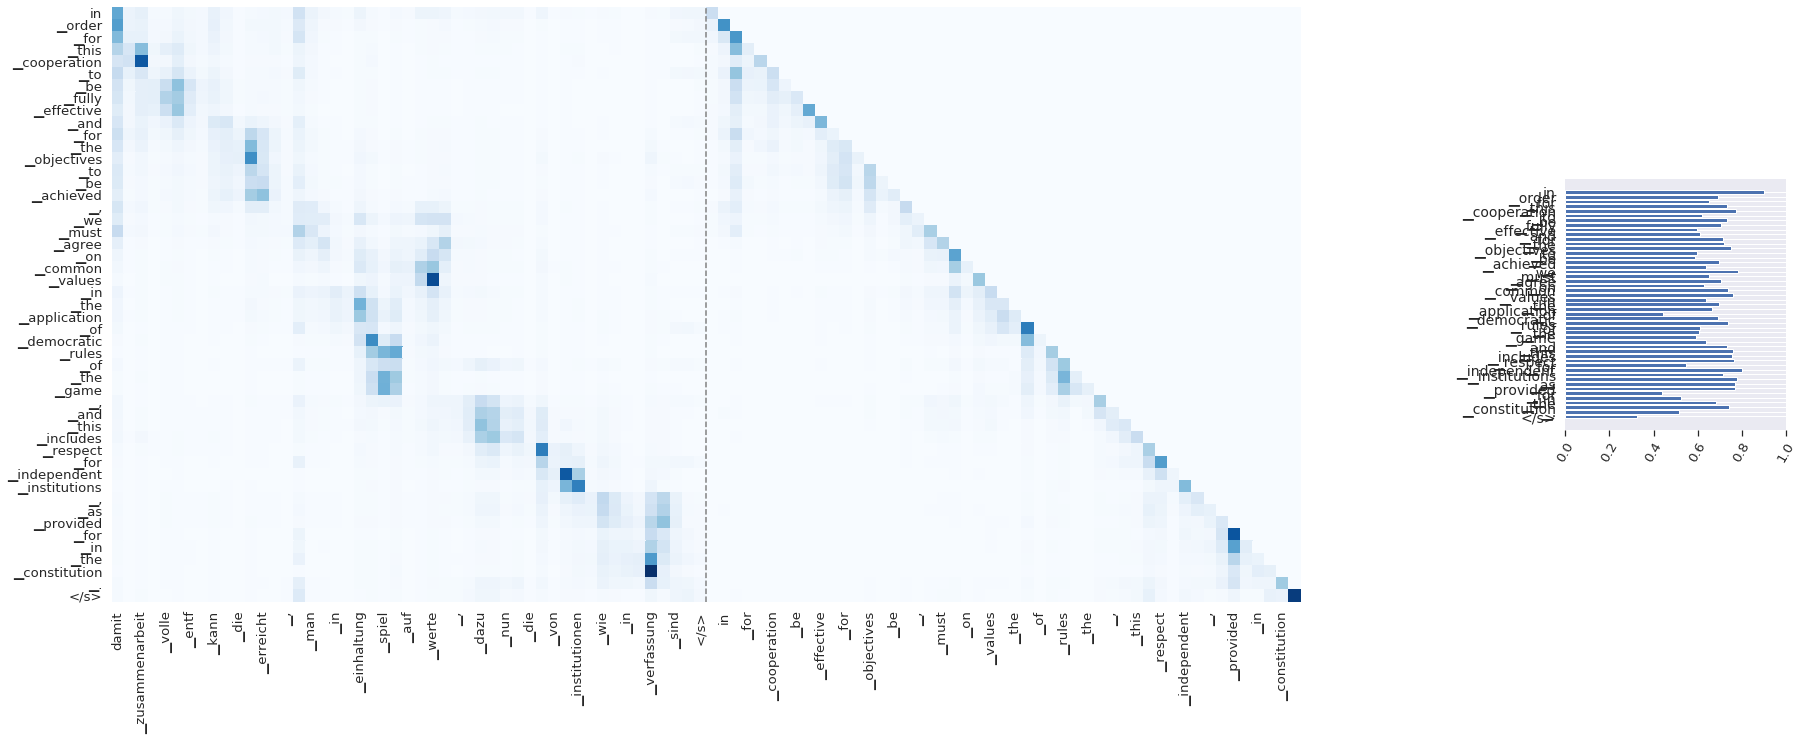

In [32]:
from matplotlib.gridspec import GridSpec

for layer in range(0,NUM_LAYERS):

    fig = plt.figure(figsize=(30, 24))
    gs = GridSpec(5, 4)
    gs.update(wspace=1.2, hspace=0.05)#0.015
    ax_main = plt.subplot(gs[0:3, :3])
    ax_yDist = plt.subplot(gs[1, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = total_alti[layer]
    contributions_alti_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    df = pd.DataFrame(contributions_alti_layer_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
    sns.set(font_scale=1.2)
    sns.heatmap(df,cmap="Blues",square=True,ax=ax_main,cbar=False)#Reds,center=0
    src_contribution = contributions_alti_layer_np[:,:len(src_tok)+1].sum(-1)
    # print(contributions_alti_layer_np[:,:len(src_tok)+1])
    # print(len(src_tok))
    df_src_contribution = pd.DataFrame(src_contribution, columns = ['src_contribution'], index = predicted_sentence + ['</s>'])
    #sns.set_style("white")
    ax_yDist.barh(range(0,len(predicted_sentence + ['</s>'])), df_src_contribution.src_contribution, align='center')
    
    plt.yticks(ticks = range(0,len(predicted_sentence + ['</s>'])) ,labels = predicted_sentence + ['</s>'],fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    #ax_main.set_title('Layer ' + str(layer+1))
    ax_main.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

    #ax_yDist.set_title('Source contribution')
    #ax_yDist.set_yticklabels([])
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    plt.xticks(rotation=60)
    ax_yDist.xaxis.grid(False)

    ax_yDist.spines['top'].set_visible(False)
    ax_yDist.spines['right'].set_visible(False)
    ax_yDist.spines['bottom'].set_visible(False)
    ax_yDist.spines['left'].set_visible(False)


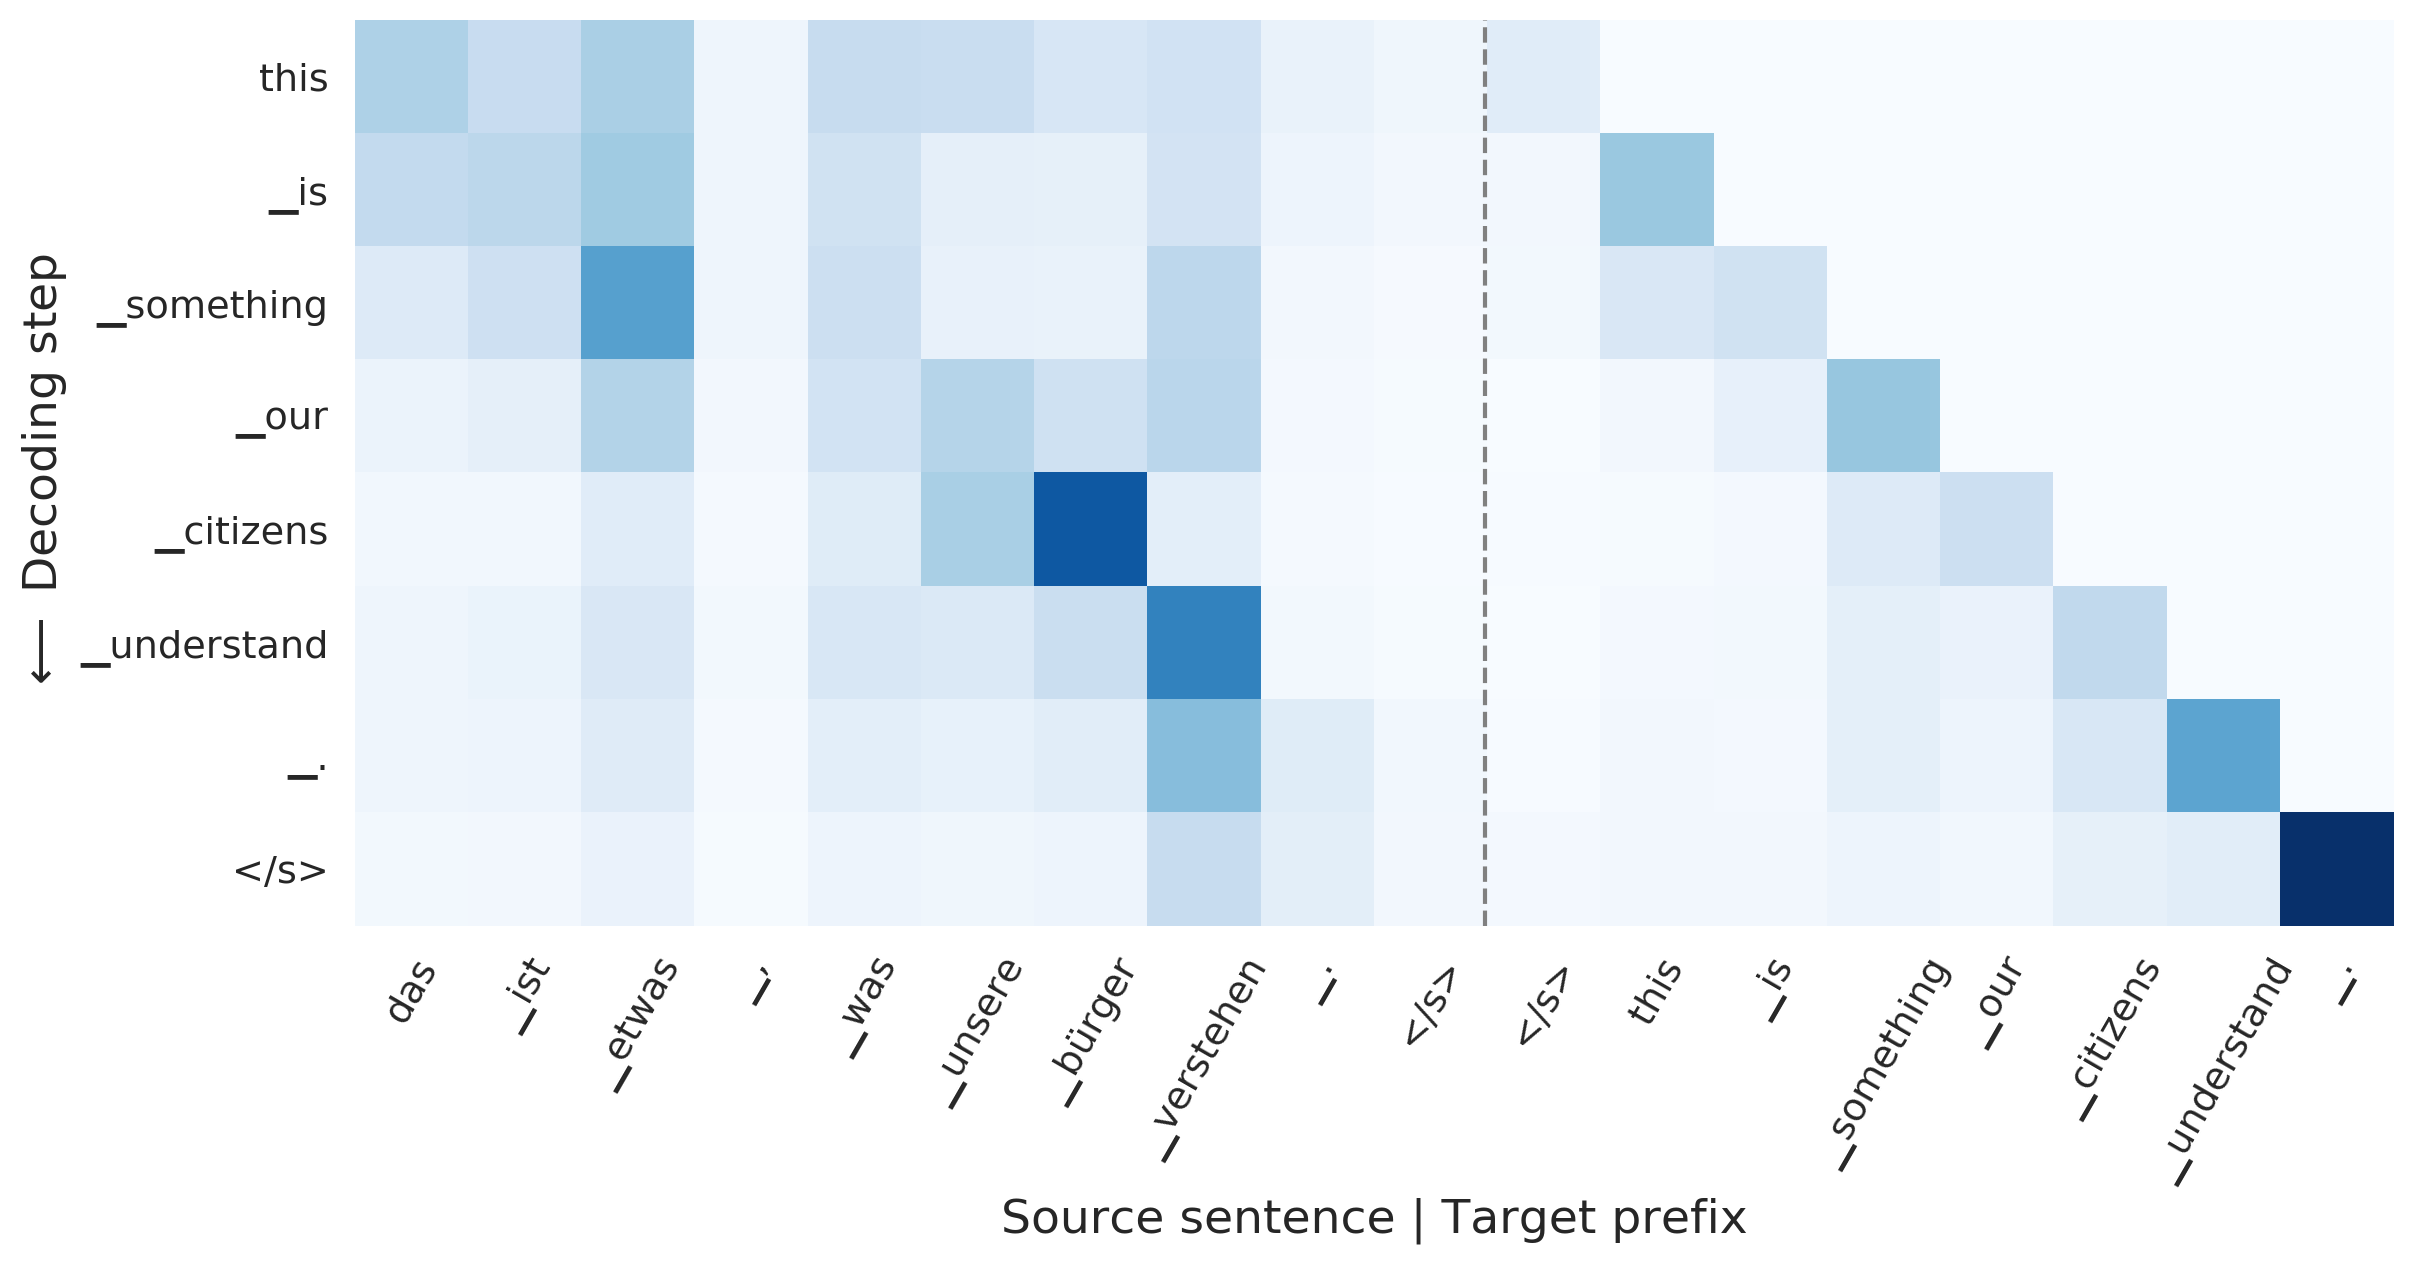

In [69]:
plt.figure(figsize=(15,6),dpi=200)
df = pd.DataFrame(contributions_alti_layer_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
sns.set(font_scale=1.25)
s = sns.heatmap(df,cmap="Blues",square=True, cbar=False)
s.set_xlabel('Source sentence | Target prefix', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15
plt.xticks(rotation=60);


### Word-word alignments (source-target) from contributions

In [ ]:
contribution_pred_src = contributions_alti_layer_np[:,:len(src_tok)+1]
src_word_to_bpe = align.convert_bpe_word(src_tok_str.split(), src_word_sent.split())
tgt_word_to_bpe = align.convert_bpe_word(tgt_tok_str.split(), tgt_word_sent.split())

#contribution_pred_src = contribution_pred_src[list(range(1,len(contribution_pred_src)))+[0]]

contributions_word_word = align.get_word_word_attention(contribution_pred_src, src_word_to_bpe, tgt_word_to_bpe, remove_EOS=False)
contributions_word_word.shape

In [ ]:
## Soft alignment
plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

In [ ]:
## Hard alignment
a_argmax = np.argmax(contributions_word_word, -1)
print(a_argmax)
contributions_word_word_hard = np.zeros(contributions_word_word.shape)

for i, j in enumerate(a_argmax):
    contributions_word_word_hard[i][j] = 1

plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

In [ ]:

# We don't consider alignment of /s (target)
contributions_word_word_hard = contributions_word_word_hard[:-1]
# Assign final mark alignments
contributions_word_word_hard[-1,-2] = 1
plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split())
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["whitesmoke", "gainsboro", "lightgrey", "lightgray", "silver",
            "darkgrey", "darkgray", "grey", "gray", "dimgrey", "dimgray", "black"]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

gold_alignment = europarl_dir / "gold_alignment/alignment.talp"

i=0
attention_matrix = np.zeros((len(tgt_word_sent.split())+1,len(src_word_sent.split())+1))
with open(gold_alignment, 'r') as f:
    line = f.readlines()[i]
    print(line)
    for alignment_string in line.split():
        t, s = align.parse_single_alignment(alignment_string, reverse=True)
        print(t,s)
        attention_matrix[t-1][s-1] = 1
#attention_matrix = attention_matrix[[len(attention_matrix)-1]+list(range(0,len(attention_matrix)-1))]

plt.figure(figsize=(8,8))
fontsize = 10
rotation = 90
df_gold = pd.DataFrame(attention_matrix, columns=src_word_sent.split()+["</s>"],index=tgt_word_sent.split()+["</s>"])
sns.heatmap(df_gold,cmap=cmap,cbar=False,square=True)
sns.set(font_scale=1)